# Predecessor follower model predictive control study - $l_1$ norm

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.sparse_l1_pfmpc import Sparse1NormPFMPC

### Platoon parameters

In [3]:
H = 100    # planning horizon
N = 50     # number of vehicles in platoon, including leader
dt = 0.1   # timestep
total_time = 15.0  # seconds
total_time += dt * H
d_des = 5      # desired spacing

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
# taus = [None] + [dt + (1 - dt) * (n-1) / N for n in range(1, N+1)]
taus = [None] + [0.5 for _ in range(N)]
dyns = [None] + [LinearLong(dt, x_min, x_max, u_min, u_max, tau) for tau in taus[1:]]
n, m, p = dyns[1].n, dyns[1].m, dyns[1].p

# algorithm
W = np.eye(p)
q_s = [None, 0] + [1 for _ in range(1, N)]
q_p = [None, 1] + [1 for _ in range(1, N)]
r = [None] + [1 for _ in range(N)]
pfmpc = [None] + [Sparse1NormPFMPC(W, q_s[i], q_p[i], r[i], dyns[i], 
                                  u_min, u_max, H)
                  for i in range(1, N+1)]

### Reference trajectory - Acceleration

In [4]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, 
                              v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

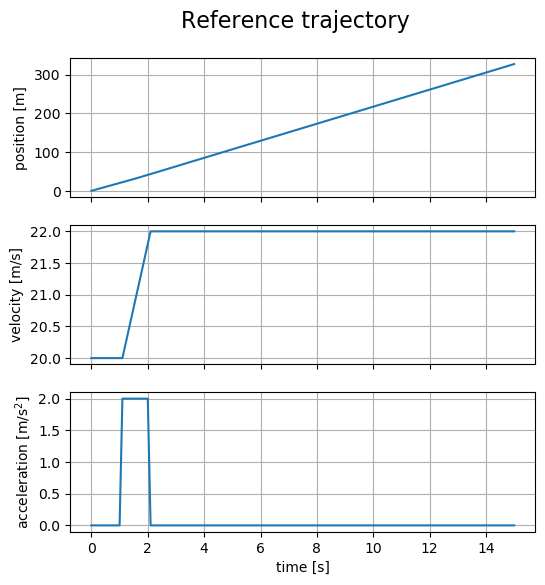

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

### Leader reference tracking

In [6]:
x_track = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

# initial condition
x_track[:, 0] = x_ref[:, 0]

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((n, H + 1))
y_a_track = np.zeros((p, H + 1))
u_a_track = np.zeros((m, H))
x_a_track[:, 0] = x_track[:, 0]
y_a_track[:, 0] = dyns[1].sense(x_a_track[:, 0])
for k in range(H):
    x_a_track[:, k+1] = dyns[1].forward(x_a_track[:, k], u_a_track[:, k])
    y_a_track[:, k+1] = dyns[1].sense(x_a_track[:, k+1])

In [7]:
start_time = time.time()
for k in range(T - H - 1):
    x_0 = x_track[:, k]
    y_a = copy.deepcopy(y_a_track)
    y_pred_a = y_ref[:, k:k+H+1]
    d = 0.

    z_opt, prob = pfmpc[1].control(x_0, y_a, y_pred_a, d)
    assert prob.status == 'optimal', \
        f"timestep {k}, problem returned: {prob.status}"

    x_opt = np.zeros((n, H+1))
    u_opt = np.zeros((m, H))
    y_opt = np.zeros((p, H+1))

    x_opt[:, 0] = x_0
    u_opt[:, 0] = z_opt[:m]
    y_opt[:, 0] = z_opt[m:m+p]
    for t, i in enumerate(range(2*m+p, len(z_opt), n+2*m+3*p)):
        x_opt[:, t+1] = z_opt[i:i+n]
        u_opt[:, t+1] = z_opt[i+n:i+n+m]
        y_opt[:, t+1] = z_opt[i+n+m:i+n+m+p]
    x_opt[:, H] = dyns[1].forward(x_opt[:, H-1], u_opt[:, H-1])
    y_opt[:, H] = dyns[1].sense(x_opt[:, H])

    for t in range(H):
        assert np.isclose(x_opt[:, t+1], 
                          dyns[1].forward(x_opt[:, t], u_opt[:, t]),
                          rtol=0.0, atol=0.01).all(), \
            f"forward dynamics constraint incorrect at timestep {k+t} | {k}: " + \
            f"{x_opt[:, t+1]} == {dyns[1].forward(x_opt[:, t], u_opt[:, t])}"
        assert u_opt[:, t] <= u_max + 0.01, \
            f"input  of {u_opt[:, t]} too large at timestep {t}"
        assert u_opt[:, t] >= u_min - 0.01, \
            f"input  of {u_opt[:, t]} too small at timestep {t}"
    for t in range(H+1):
        assert np.isclose(y_opt[:, t], dyns[1].sense(x_opt[:, t]),
                          rtol=0.0, atol=0.01).all(), \
            f"output constraint incorrect at timestep {t}"

    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyns[1].forward(x_0, u_opt[:, 0])

    # print(f"timestep {k}:\n" + 
    #       f"  x_0: {x_0}\n" + 
    #       f"  y_a_0: {y_a[:, 0]}\n" + 
    #       f"  y_p_a_0: {y_pred_a[:, 0]}\n" + 
    #       f"  y_a_H: {y_a[:, -1]}\n" + 
    #       f"  y_p_a_H: {y_pred_a[:, -1]}\n"
    # )

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = np.zeros((m))
    x_a_track[:, 0] = x_opt[:, 1]
    y_a_track[:, 0] = dyns[1].sense(x_a_track[:, 0])
    for t in range(H):
        x_a_track[:, t+1] = dyns[1].forward(x_a_track[:, t], u_a_track[:, t])
        y_a_track[:, t+1] = dyns[1].sense(x_a_track[:, t+1])
    
end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

In [8]:
print(f"pf mpc leader track avg rate: {1 / avg_time} Hz")
print("\nproblem data:")
print(f"    scalar variables: {prob.size_metrics.num_scalar_variables}")
print(f"    scalar eq constraints: {prob.size_metrics.num_scalar_eq_constr}")
print(f"    scalar ineq constraints: {prob.size_metrics.num_scalar_leq_constr}")

pf mpc leader track avg rate: 59.54355487505291 Hz

problem data:
    scalar variables: 1093
    scalar eq constraints: 500
    scalar ineq constraints: 1192


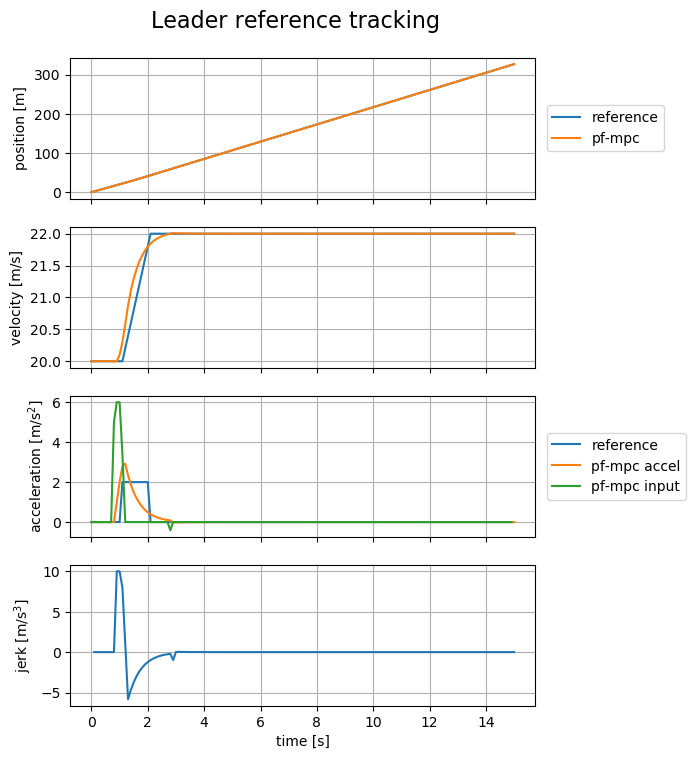

In [9]:
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

# ax[0].plot(t_range[:T-H], np.zeros(T-H), label="reference")
# ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
# ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', 
#            transform=ax[0].transAxes)
for i in range(1, x_ref.shape[0] + 1):
    ax[i-1].plot(t_range_mpc, x_ref[i-1, :T-H], label="reference")

ax[0].plot(t_range_mpc, x_track[0, :], label="pf-mpc")
ax[1].plot(t_range_mpc, x_track[1, :], label="pf-mpc")
ax[2].plot(t_range_mpc, x_track[2, :], label="pf-mpc accel")
ax[2].plot(t_range_mpc[:-1], u_track[0, :], label="pf-mpc input")

# ax[0].set_ylabel("spacing error [m]")
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[3].set_xlabel("time [s]")
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[2].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")

lead_jerk = (x_track[2, 1:] - x_track[2, :-1]) / dt
ax[3].plot(t_range_mpc[1:], lead_jerk)
ax[3].set_ylabel(r"jerk [m/s$^3$]")

for a in ax.flatten():
    a.grid()

## Predecessor follower platoon analysis

In [10]:
x_pfmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
u_pfmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_pfmpc[0] = x_ref[:, :T-H]
u_pfmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_pfmpc[0][1, 0], x_pfmpc[0][2, 0]])

# initialize assumed states, controls, and output for first timestep
x_a_pfmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
x_a_pfmpc[0] = x_pfmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_pfmpc[i][:, 0] = x_pfmpc[i][:, 0]

y_a_pfmpc = [np.zeros((p, H + 1)) for _ in range(N + 1)]
y_a_pfmpc[0] = x_pfmpc[0][:2, :H+1]
for i in range(1, N + 1):
    y_a_pfmpc[i][:, 0] = dyns[i].sense(x_a_pfmpc[i][:, 0])

u_a_pfmpc = [np.zeros((m, H)) for _ in range(N + 1)]
u_a_pfmpc[0] = u_pfmpc[0][:H]

for i in range(1, N+1):
    for k in range(H):
        x_a_pfmpc[i][:, k+1] = dyns[i].forward(x_a_pfmpc[i][:, k], 
                                           u_a_pfmpc[i][:, k])
        y_a_pfmpc[i][:, k+1] = dyns[i].sense(x_a_pfmpc[i][:, k+1])

x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

In [11]:
start_time = time.time()
no_soln = False
for k in tqdm(range(T - H - 1)):
    for i in range(1, N + 1):
        x_0 = x_pfmpc[i][:, k]
        y_a = y_a_pfmpc_prev[i]
        y_pred_a = y_a_pfmpc_prev[i-1]
        d = 0 if i == 1 else d_des

        z_opt, prob = pfmpc[i].control(x_0, y_a, y_pred_a, d)
        if 'optimal' not in prob.status:
            print(f"timestep {k}, vehicle {i}, problem returned: {prob.status}")
            no_soln = True
            break

        x_opt = np.zeros((n, H+1))
        u_opt = np.zeros((m, H))
        y_opt = np.zeros((p, H+1))

        x_opt[:, 0] = x_0
        u_opt[:, 0] = z_opt[:m]
        y_opt[:, 0] = z_opt[m:m+p]
        for t, j in enumerate(range(2*m+p, len(z_opt), n+2*m+3*p)):
            x_opt[:, t+1] = z_opt[j:j+n]
            u_opt[:, t+1] = z_opt[j+n:j+n+m]
            y_opt[:, t+1] = z_opt[j+n+m:j+n+m+p]
        x_opt[:, H] = dyns[1].forward(x_opt[:, H-1], u_opt[:, H-1])
        y_opt[:, H] = dyns[1].sense(x_opt[:, H])

        u_pfmpc[i][:, k] = u_opt[:, 0]
        x_pfmpc[i][:, k+1] = dyns[i].forward(x_0, u_opt[:, 0])

        # update assumed state, control, input
        u_a_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_pfmpc[i][:, H-1] = np.zeros((dyns[i].m))
        x_a_pfmpc[i][:, 0] = x_opt[:, 1]
        y_a_pfmpc[i][:, 0] = dyns[i].sense(x_a_pfmpc[i][:, 0])
        for t in range(H):
            x_a_pfmpc[i][:, t+1] = dyns[i].forward(x_a_pfmpc[i][:, t], 
                                                   u_a_pfmpc[i][:, t])
            y_a_pfmpc[i][:, t+1] = dyns[i].sense(x_a_pfmpc[i][:, t+1])
    
    if no_soln:
        fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
        fig.suptitle(f"timestep {k}, vehicle {i} failure", size=16)
        fig.subplots_adjust(top=0.9)
        for i in range(N+1):
            ax[0].plot(t_range[:H+1], y_a_pfmpc_prev[i][0, :], 
                       label=f"{i} assumed")
            ax[1].plot(t_range[:H+1], y_a_pfmpc_prev[i][1, :], 
                       label=f"{i} assumed")
        ax[0].set_ylabel("position [m]")
        ax[0].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        ax[1].set_ylabel("velocity [m/s]")
        ax[1].set_xlabel("time [s]")
        ax[1].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        break
    
    x_a_pfmpc[0] = x_ref[:, k+1:k+H+2]
    y_a_pfmpc[0] = x_ref[:2, k+1:k+H+2]
    u_a_pfmpc[0] = x_ref[2, k+1:k+H+1]

    x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
    y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
    u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (i * (k+1))

100%|██████████| 150/150 [01:26<00:00,  1.74it/s]


In [12]:
print(f"\npf-mpc average rate: {1 / avg_time} Hz")


pf-mpc average rate: 86.9991362196853 Hz


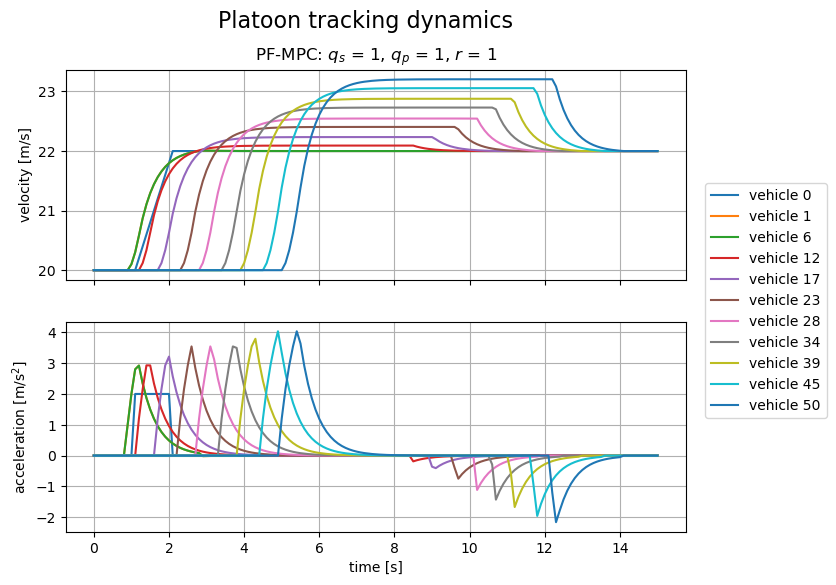

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(rf"PF-MPC: $q_s$ = {q_s[2]}, $q_p$ = {q_p[2]}, $r$ = {r[2]}")
fig.subplots_adjust(top=0.88)

ax[0].plot(t_range_mpc, x_pfmpc[0][1, :], label=f"vehicle 0")
ax[1].plot(t_range_mpc, x_pfmpc[0][2, :], label=f"vehicle 0")
for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0].plot(t_range_mpc, x_pfmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_pfmpc[i][2, :], label=f"vehicle {i}")

ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left");

In [14]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[0][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[0][1, :]

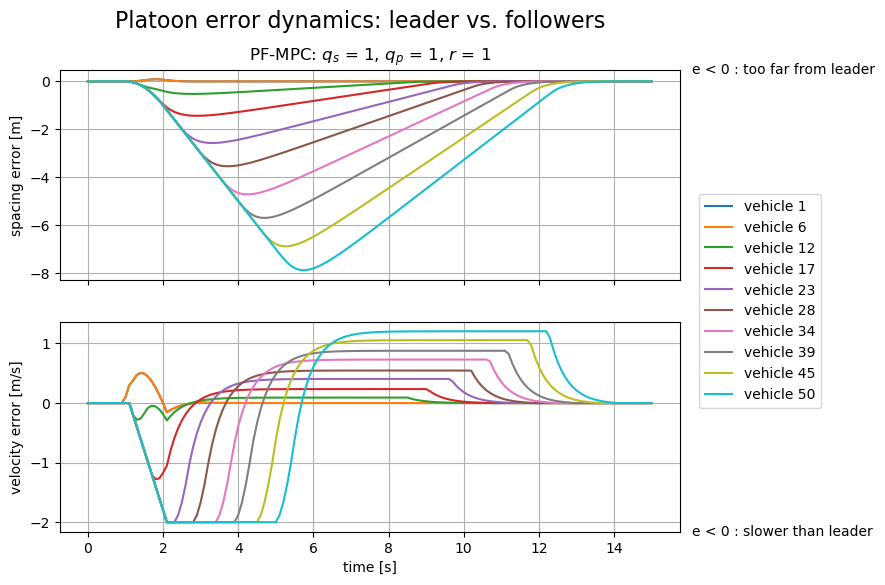

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(rf"PF-MPC: $q_s$ = {q_s[2]}, $q_p$ = {q_p[2]}, $r$ = {r[2]}")
fig.subplots_adjust(top=0.88)

for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left");

In [16]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[i-1][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[i-1][1, :]

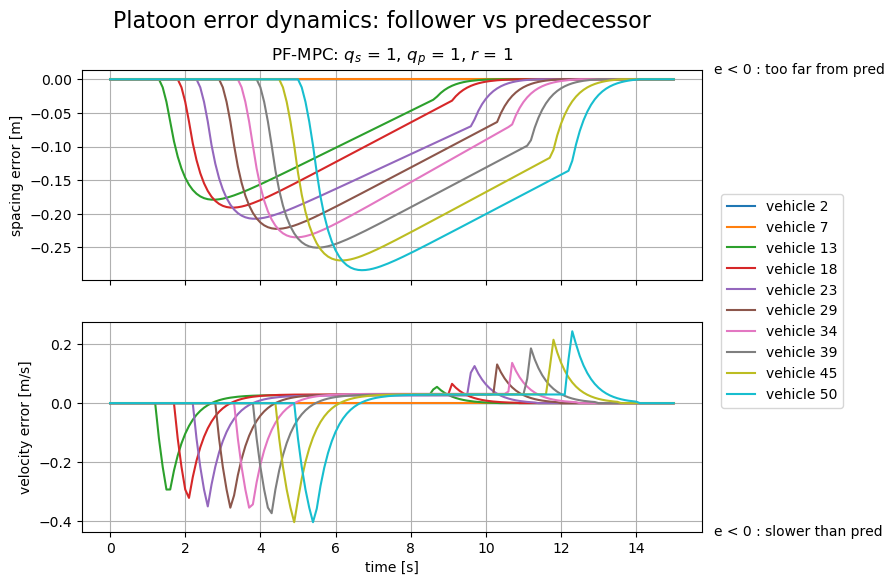

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(rf"PF-MPC: $q_s$ = {q_s[2]}, $q_p$ = {q_p[2]}, $r$ = {r[2]}")
fig.subplots_adjust(top=0.88)

for i in np.linspace(2, N, min(N-1, 10)).round().astype(int):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left");